In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
import time
from numba_progress import ProgressBar
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, get_trajs, speed_windowed, theta_windowed

show_verb = True
save_verb = True
anim_show_verb = False

In [3]:
rawTrajs = pd.read_parquet("../data/tracking/pre_merge_tracking.parquet")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle != red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle == red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")


# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")


# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}
    
maxLagtime = 1000
#x = np.arange(0.1, 100.1, 0.1) # without initial point
x = np.arange(0, 100, 0.1) # with initial point

blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)

nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


In [4]:
def get_velocities(trajList):
    v = np.zeros((len(trajList), 2, len(trajList[0])), dtype=np.float64)
    for i in range(len(trajList)):
        v[i] = np.array(trajList[i].v).T
    return v

In [7]:
def smoothing(rawTrajs, nDrops, windLen, orderofPoly):
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = rawTrajs.copy()
    for i in range(nDrops):
        smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values,
                                                                        windLen, orderofPoly)
        smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values,
                                                                        windLen, orderofPoly)    
        
    return smoothTrajs

In [8]:
maxLagtime = 1000
x = np.arange(0, 100, 0.1) # with initial point
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
v_b = get_velocities(blueTrajs)

In [9]:
@njit
def nb_mean_ax0(arr):
    out = np.empty(arr.shape[1], dtype=np.float64)
    for ax in range(arr.shape[1]):
        out[ax] = np.mean(arr[:, ax])
    return out

@njit
def nb_std_ax0(arr):
    out = np.empty(arr.shape[1], dtype=np.float64)
    for ax in range(arr.shape[1]):
        out[ax] = np.std(arr[:, ax])
    return out

In [10]:
@njit(parallel=True, fastmath=True)
def get_corr2(velocities, maxLagtime_):
    a = np.zeros((velocities.shape[0], maxLagtime_, 2, 2))
    b = np.zeros((velocities.shape[0], maxLagtime_, 2, 2))
    for i in prange(velocities.shape[0]):
        v = velocities[i]
        a[i, 0] = np.corrcoef(v[0], v[0])
        b[i, 0] = np.corrcoef(v[1], v[1])
        for lag_ in prange(1, maxLagtime_):
            a[i, lag_] = np.corrcoef(v[0, :-lag_], v[0, lag_:])
            b[i, lag_] = np.corrcoef(v[1, :-lag_], v[1, lag_:])
    return a[:, :, 0, 1], b[:, :, 0, 1]

In [11]:
smoothTrajs = smoothing(rawTrajs, nDrops, windList[k], 2)
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
v_b_smooth = get_velocities(blueTrajs_smooth)

NameError: name 'windList' is not defined

In [13]:
corr = np.zeros((2, maxLagtime))
corr_std = np.zeros((2, maxLagtime))
a, b = get_corr2(v_b, maxLagtime)
corr = [a.mean(axis=0), b.mean(axis=0)]
corr_std = [a.std(axis=0), b.std(axis=0)]

In [22]:
windList = np.arange(3, 13, 1, dtype=int)

corr_smooth = np.zeros((len(windList), 2, maxLagtime))
corr_std_smooth = np.zeros((len(windList), 2, maxLagtime))
                            
for k in tqdm(range(10)):
    smoothTrajs = smoothing(rawTrajs, nDrops, windList[k], 2)
    blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
    v_b_smooth = get_velocities(blueTrajs_smooth)

    a, b = get_corr2(v_b_smooth, maxLagtime)
    corr_smooth[k] = [a.mean(axis=0), b.mean(axis=0)]
    corr_std_smooth[k] = [a.std(axis=0), b.std(axis=0)]

100%|██████████| 10/10 [05:01<00:00, 30.16s/it]


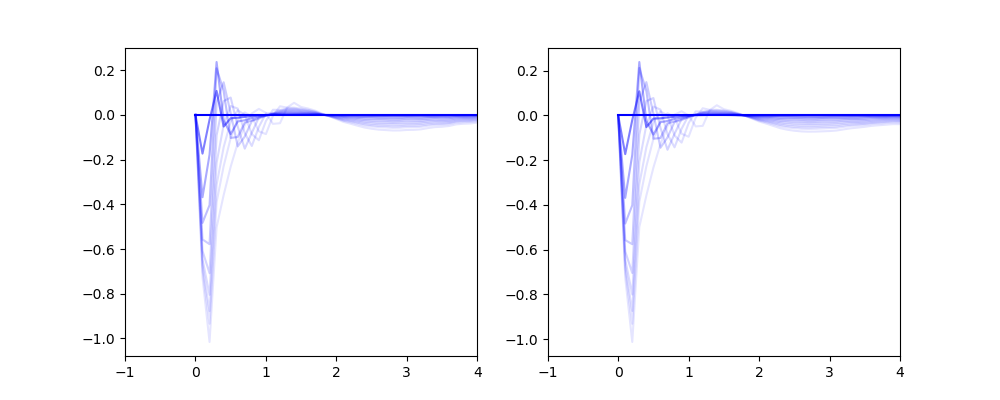

In [27]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
for i in range(0, 10):
    ax.plot(x, corr[0] - corr_smooth[i, 0], '-b', alpha = 1/(i+1))
ax.set_xlim(-1, 4)
#ax.legend()
for i in range(0, 10):
    ax1.plot(x, corr[1] - corr_smooth[i, 1], 'b', alpha = 1/(i+1))
#ax1.legend()
ax1.set_xlim(-1, 4)
plt.show()

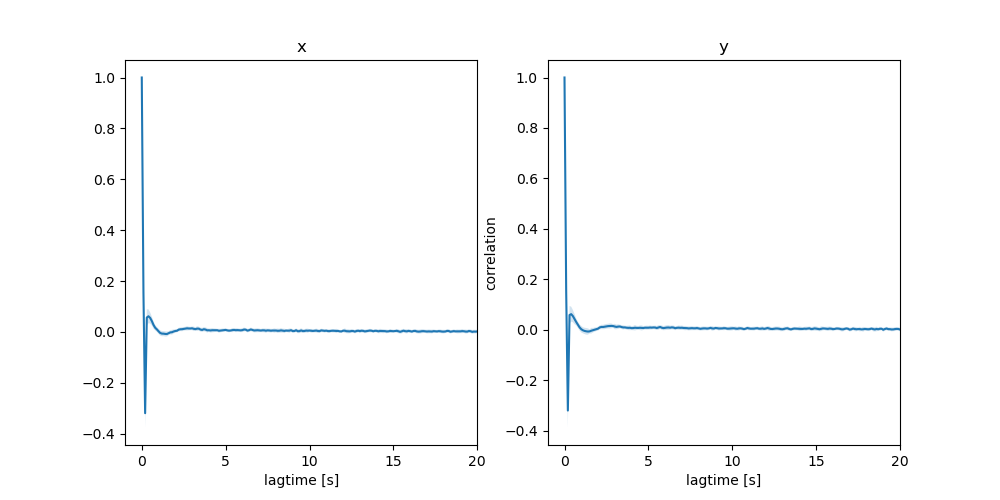

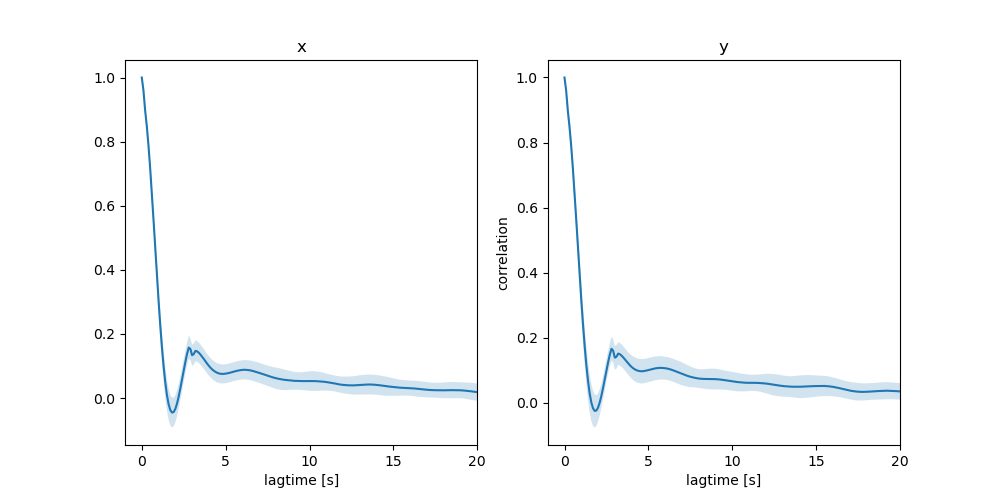

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A)
ax[0].fill_between(x, A - A_std, A + A_std, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B, label="y")
ax[1].fill_between(x, B - B_std, B + B_std, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A_smooth)
ax[0].fill_between(x, A_smooth - A_std_smooth, A_smooth + A_std_smooth, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B_smooth, label="y")
ax[1].fill_between(x, B_smooth - B_std_smooth, B_smooth + B_std_smooth, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()
